#### This code was written by the author with the assistance of AI tools for guidance and debugging.


In [76]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, IsolationForest
from sklearn.cluster import KMeans
from sklearn.model_selection import TimeSeriesSplit

from sklearn.metrics import (
    classification_report,
    accuracy_score,
    f1_score,
    roc_auc_score,
    roc_curve,
    confusion_matrix,
    ConfusionMatrixDisplay,
    silhouette_score,
    auc
)


In [45]:
def make_preprocessor(X_df):
    numeric_features = X_df.select_dtypes(include=["int64", "float64"]).columns.tolist()
    categorical_features = X_df.select_dtypes(include=["object"]).columns.tolist()

    numeric_transformer = Pipeline(steps=[("scaler", StandardScaler())])
    categorical_transformer = Pipeline(steps=[("onehot", OneHotEncoder(handle_unknown="ignore"))])

    return ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, numeric_features),
            ("cat", categorical_transformer, categorical_features)
        ]
    )


In [ ]:
url = "https://raw.githubusercontent.com/mor2800/Mor-Heymann/main/data/Selected_Online_Sport_Wagering_Data%20(1).csv"
df = pd.read_csv(url)

# Parse dates
df["Month Ending"] = pd.to_datetime(df["Month Ending"].astype(str).str.strip(), errors="coerce")
print("Invalid dates:", df["Month Ending"].isna().sum())

# Drop invalid dates 
df = df.dropna(subset=["Month Ending"]).sort_values("Month Ending").reset_index(drop=True)

print("Rows, Columns:", df.shape)
display(df.head())


Invalid dates: 0
Rows, Columns: (144, 15)


/var/folders/g5/xwsvl7vn15d42_q16xxg893r0000gn/T/ipykernel_48900/810551177.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["Month Ending"] = pd.to_datetime(df["Month Ending"].astype(str).str.strip(), errors="coerce")


,Licensee,Fiscal Year,Month Ending,Wagers,Patron Winnings,Cancelled Wagers,Monthly Resettlements (3),Online Sports Wagering Win/(Loss),Federal Excise Tax (4),Unadjusted Monthly Gaming Revenue,Promotional Coupons or Credits Wagered (5),Promotional Deduction (6),Total Gross Gaming Revenue,Payment (7),Notes
0,CT Lottery Corp,2021/22,2021-10-31,3246536,2901339,41418,10047,293732,8013,285720,404431,71430,214290,29465,NaN
1,"Mohegan Digital, LLC",2021/22,2021-10-31,27082842,26047082,102765,58834,874160,61453,812707,2398934,203177,609530,83810,NaN
2,"MPI Master Wagering License CT, LLC",2021/22,2021-10-31,23770250,20117086,43488,-4121,3613797,53427,3560370,2119449,890092,2670277,367163,"8,9"
3,"MPI Master Wagering License CT, LLC",2021/22,2021-11-30,60031024,52870165,164994,28431,6967434,143877,6823557,2045623,1705889,5117667,703679,8
4,CT Lottery Corp,2021/22,2021-11-30,8518887,7660972,99459,-3267,761722,21279,740443,405253,185111,555332,76358,NaN


In [47]:
print("Rows, Columns:", df.shape)

print("\nColumns:")
print(df.columns.tolist())

print("\nData types:")
display(df.dtypes)

print("\nMissing values (%):")
missing_pct = (df.isna().mean() * 100).sort_values(ascending=False)
print(missing_pct)


Rows, Columns: (144, 15)

Columns:
['Licensee', 'Fiscal Year', 'Month Ending', 'Wagers', 'Patron Winnings', 'Cancelled Wagers', 'Monthly Resettlements (3)', 'Online Sports Wagering Win/(Loss)', 'Federal Excise Tax (4)', 'Unadjusted Monthly Gaming Revenue', 'Promotional Coupons or Credits Wagered (5)', 'Promotional Deduction (6)', 'Total Gross Gaming Revenue', 'Payment (7)', 'Notes']

Data types:


Licensee                                              object
Fiscal Year                                           object
Month Ending                                  datetime64[ns]
Wagers                                                 int64
Patron Winnings                                        int64
Cancelled Wagers                                       int64
Monthly Resettlements (3)                              int64
Online Sports Wagering Win/(Loss)                      int64
Federal Excise Tax (4)                                 int64
Unadjusted Monthly Gaming Revenue                      int64
Promotional Coupons or Credits Wagered (5)             int64
Promotional Deduction (6)                              int64
Total Gross Gaming Revenue                             int64
Payment (7)                                            int64
Notes                                                 object
dtype: object


Missing values (%):
Notes                                         94.444444
Licensee                                       0.000000
Fiscal Year                                    0.000000
Month Ending                                   0.000000
Wagers                                         0.000000
Patron Winnings                                0.000000
Cancelled Wagers                               0.000000
Monthly Resettlements (3)                      0.000000
Online Sports Wagering Win/(Loss)              0.000000
Federal Excise Tax (4)                         0.000000
Unadjusted Monthly Gaming Revenue              0.000000
Promotional Coupons or Credits Wagered (5)     0.000000
Promotional Deduction (6)                      0.000000
Total Gross Gaming Revenue                     0.000000
Payment (7)                                    0.000000
dtype: float64


In [48]:
display(df[["Month Ending"]].head(10))


,Month Ending
0,2021-10-31
1,2021-10-31
2,2021-10-31
3,2021-11-30
4,2021-11-30
5,2021-11-30
6,2021-12-31
7,2021-12-31
8,2021-12-31
9,2022-01-31


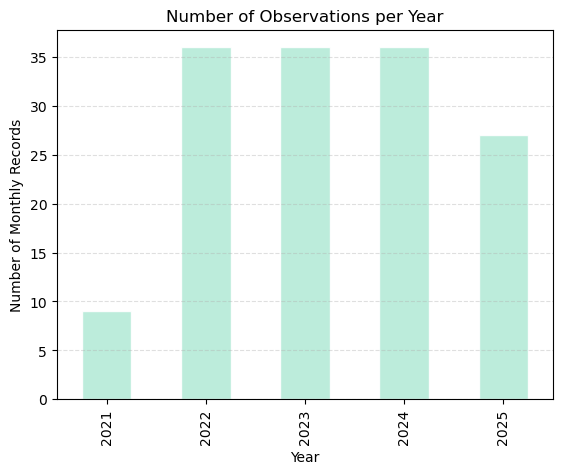

In [49]:
years = df["Month Ending"].dt.year

plt.figure()
years.value_counts().sort_index().plot(
    kind="bar",
    color="#B5EAD7",      # ירוק פסטלי
    edgecolor="white",
    alpha=0.9
)

plt.title("Number of Observations per Year")
plt.xlabel("Year")
plt.ylabel("Number of Monthly Records")
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.show()


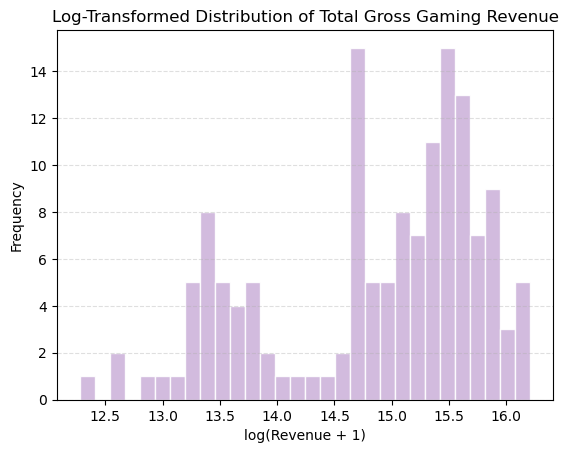

In [ ]:
plt.figure()

plt.hist(
    np.log1p(df["Total Gross Gaming Revenue"]),
    bins=30,
   color="#CDB4DB"
,     
    edgecolor="white",
    alpha=0.9
)

plt.title("Log-Transformed Distribution of Total Gross Gaming Revenue")
plt.xlabel("log(Revenue + 1)")
plt.ylabel("Frequency")

plt.grid(axis="y", linestyle="--", alpha=0.4)

plt.show()


In [51]:
#  Create binary target variable
target_col = "Total Gross Gaming Revenue"

# Calculate median
median_revenue = df[target_col].median()

# Create binary target
df["target_high_revenue"] = (df[target_col] >= median_revenue).astype(int)

print("Median revenue:", median_revenue)
print("\nTarget value counts:")
print(df["target_high_revenue"].value_counts())

print("\nTarget distribution (%):")
print(df["target_high_revenue"].value_counts(normalize=True).round(3))


Median revenue: 3760814.5

Target value counts:
target_high_revenue
0    72
1    72
Name: count, dtype: int64

Target distribution (%):
target_high_revenue
0    0.5
1    0.5
Name: proportion, dtype: float64


In [52]:
LEAK_COLS = [
    "Total Gross Gaming Revenue",
    "Unadjusted Monthly Gaming Revenue",
    "Online Sports Wagering Win/(Loss)",
    "Payment (7)",
    "Federal Excise Tax (4)",
    "Promotional Deduction (6)"
]
BASE_DROP = ["target_high_revenue", "Month Ending", "Notes"]


In [53]:
# Extract temporal features from Month Ending
df["month"] = df["Month Ending"].dt.month
df["year"] = df["Month Ending"].dt.year

display(df[["Month Ending", "month", "year"]].head(10))


,Month Ending,month,year
0,2021-10-31,10,2021
1,2021-10-31,10,2021
2,2021-10-31,10,2021
3,2021-11-30,11,2021
4,2021-11-30,11,2021
5,2021-11-30,11,2021
6,2021-12-31,12,2021
7,2021-12-31,12,2021
8,2021-12-31,12,2021
9,2022-01-31,1,2022


In [54]:
drop_cols = BASE_DROP + LEAK_COLS
X = df.drop(columns=drop_cols)
y = df["target_high_revenue"]


In [55]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train distribution:")
print(y_train.value_counts())
print("y_test distribution:")
print(y_test.value_counts())


X_train shape: (115, 9)
X_test shape: (29, 9)
y_train distribution:
target_high_revenue
1    58
0    57
Name: count, dtype: int64
y_test distribution:
target_high_revenue
0    15
1    14
Name: count, dtype: int64


In [56]:
numeric_features = X_train.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_features = X_train.select_dtypes(include=["object"]).columns.tolist()


In [57]:
preprocessor_r = make_preprocessor(X_train)

In [58]:
# Logistic Regression (Random Split)
logreg_model = Pipeline([
    ("preprocessor", preprocessor_r),
    ("classifier", LogisticRegression(max_iter=1000, random_state=42))
])

# Train
logreg_model.fit(X_train, y_train)

# Predict
y_pred_logreg = logreg_model.predict(X_test)

# Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred_logreg))
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred_logreg))


Accuracy: 1.0

Classification Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       1.00      1.00      1.00        14

    accuracy                           1.00        29
   macro avg       1.00      1.00      1.00        29
weighted avg       1.00      1.00      1.00        29



In [59]:
# Build pipeline with Decision Tree
dt_model = Pipeline(
    steps=[
        ("preprocessor", preprocessor_r),
        ("classifier", DecisionTreeClassifier(max_depth=5, random_state=42))
    ]
)


dt_model.fit(X_train, y_train)

y_pred_dt = dt_model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred_dt))
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred_dt))


Accuracy: 0.9310344827586207

Classification Report:

              precision    recall  f1-score   support

           0       0.93      0.93      0.93        15
           1       0.93      0.93      0.93        14

    accuracy                           0.93        29
   macro avg       0.93      0.93      0.93        29
weighted avg       0.93      0.93      0.93        29



In [60]:
# Random Forest (Random Split)
rf_model = Pipeline(
    steps=[
        ("preprocessor", preprocessor_r),
        ("classifier", RandomForestClassifier(n_estimators=100, random_state=42))
    ]
)

rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred_rf))


Accuracy: 1.0

Classification Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       1.00      1.00      1.00        14

    accuracy                           1.00        29
   macro avg       1.00      1.00      1.00        29
weighted avg       1.00      1.00      1.00        29



In [61]:
# TIME-BASED SPLIT for all time-based models
df = df.sort_values("Month Ending").reset_index(drop=True)

drop_cols = BASE_DROP + LEAK_COLS
X_all = df.drop(columns=drop_cols, errors="ignore")
y_all = df["target_high_revenue"]

split_idx = int(len(df) * 0.8)

X_train_t = X_all.iloc[:split_idx]
X_test_t  = X_all.iloc[split_idx:]
y_train_t = y_all.iloc[:split_idx]
y_test_t  = y_all.iloc[split_idx:]

print("Train period:", df["Month Ending"].iloc[0], "->", df["Month Ending"].iloc[split_idx-1])
print("Test period :", df["Month Ending"].iloc[split_idx], "->", df["Month Ending"].iloc[-1])
print("\nTrain distribution:\n", y_train_t.value_counts())
print("\nTest distribution:\n", y_test_t.value_counts())


Train period: 2021-10-31 00:00:00 -> 2024-12-31 00:00:00
Test period : 2024-12-31 00:00:00 -> 2025-09-30 00:00:00

Train distribution:
 target_high_revenue
0    62
1    53
Name: count, dtype: int64

Test distribution:
 target_high_revenue
1    19
0    10
Name: count, dtype: int64


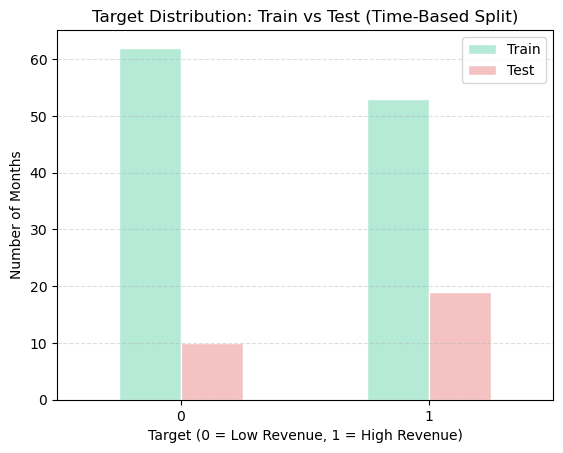

In [62]:
train_counts = y_train_t.value_counts().sort_index()
test_counts = y_test_t.value_counts().sort_index()

dist_df = pd.DataFrame({"Train": train_counts, "Test": test_counts}).fillna(0)

ax = dist_df.plot(
    kind="bar",
    color=["#B5EAD7", "#F4C2C2"],
    edgecolor="white"
)

ax.set_title("Target Distribution: Train vs Test (Time-Based Split)")
ax.set_xlabel("Target (0 = Low Revenue, 1 = High Revenue)")
ax.set_ylabel("Number of Months")
plt.xticks(rotation=0)
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.show()


In [63]:
preprocessor_t = make_preprocessor(X_train_t)


In [64]:
logreg_time = Pipeline(
    steps=[
        ("preprocessor", preprocessor_t),
        ("classifier", LogisticRegression(max_iter=1000, random_state=42))
    ]
)


# Train on past data
logreg_time.fit(X_train_t, y_train_t)

# Predict future data
y_pred_time = logreg_time.predict(X_test_t)

print("Accuracy:", accuracy_score(y_test_t, y_pred_time))
print("\nClassification Report:\n")
print(classification_report(y_test_t, y_pred_time))
y_proba_time = logreg_time.predict_proba(X_test_t)[:, 1]
auc_time = roc_auc_score(y_test_t, y_proba_time)
print("ROC-AUC:", round(auc_time, 3))



Accuracy: 0.9310344827586207

Classification Report:

              precision    recall  f1-score   support

           0       0.90      0.90      0.90        10
           1       0.95      0.95      0.95        19

    accuracy                           0.93        29
   macro avg       0.92      0.92      0.92        29
weighted avg       0.93      0.93      0.93        29

ROC-AUC: 0.989


<Figure size 640x480 with 0 Axes>

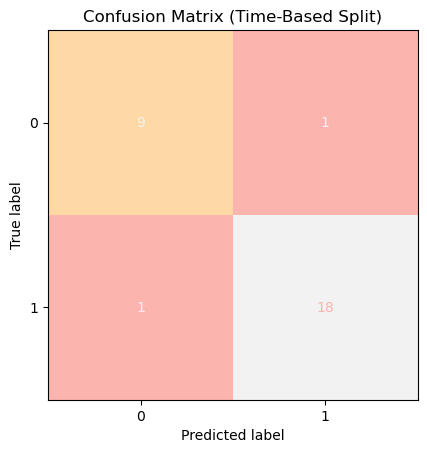

In [65]:
# Confusion Matrix for time-based split
cm = confusion_matrix(y_test_t, y_pred_time)

plt.figure()
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap="Pastel1", values_format="d", colorbar=False)

plt.title("Confusion Matrix (Time-Based Split)")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.show()


,Split,Accuracy,F1 (macro)
0,Random Split,0.965517,0.965352
1,Time-Based Split,0.931034,0.923684


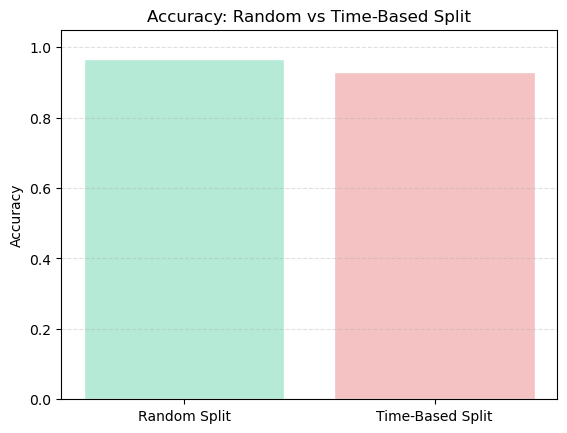

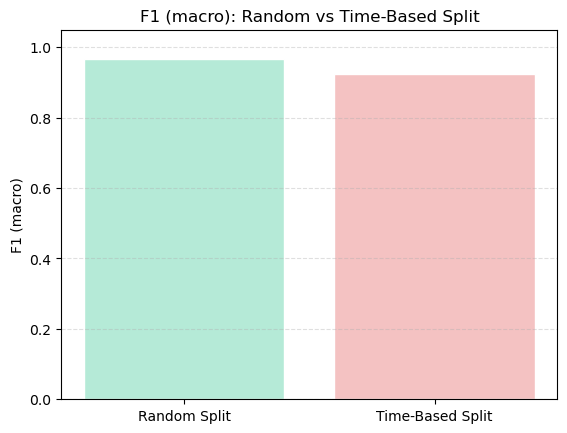

In [ ]:
#  Random split (comparison only) 
drop_cols = BASE_DROP + LEAK_COLS
X_all = df.drop(columns=drop_cols, errors="ignore")
y_all = df["target_high_revenue"]

X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(
    X_all, y_all, test_size=0.2, random_state=42, stratify=y_all
)

logreg_random = Pipeline([
    ("preprocessor", make_preprocessor(X_train_r)),
    ("classifier", LogisticRegression(max_iter=1000, random_state=42))
])

logreg_random.fit(X_train_r, y_train_r)
y_pred_random = logreg_random.predict(X_test_r)

# compare random (new) vs time (already computed above)
results = pd.DataFrame({
    "Split": ["Random Split", "Time-Based Split"],
    "Accuracy": [
        accuracy_score(y_test_r, y_pred_random),
        accuracy_score(y_test_t, y_pred_time)   
    ],
    "F1 (macro)": [
        f1_score(y_test_r, y_pred_random, average="macro"),
        f1_score(y_test_t, y_pred_time, average="macro")
    ]
})

display(results)

plt.figure()
plt.bar(results["Split"], results["Accuracy"],
        color=["#B5EAD7", "#F4C2C2"], edgecolor="white")
plt.title("Accuracy: Random vs Time-Based Split")
plt.ylabel("Accuracy")
plt.ylim(0, 1.05)
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.show()

plt.figure()
plt.bar(results["Split"], results["F1 (macro)"],
        color=["#B5EAD7", "#F4C2C2"], edgecolor="white")
plt.title("F1 (macro): Random vs Time-Based Split")
plt.ylabel("F1 (macro)")
plt.ylim(0, 1.05)
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.show()


In [67]:
rf_time = Pipeline(
    steps=[
        ("preprocessor", preprocessor_t),
        ("classifier", RandomForestClassifier(n_estimators=200, random_state=42))
    ]
)


rf_time.fit(X_train_t, y_train_t)
y_pred_rf_time = rf_time.predict(X_test_t)

print("Accuracy:", accuracy_score(y_test_t, y_pred_rf_time))
print("\nClassification Report:\n")
print(classification_report(y_test_t, y_pred_rf_time))
y_proba_rf_time = rf_time.predict_proba(X_test_t)[:, 1]
auc_rf_time = roc_auc_score(y_test_t, y_proba_rf_time)
print("ROC-AUC:", round(auc_rf_time, 3))


Accuracy: 1.0

Classification Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00        19

    accuracy                           1.00        29
   macro avg       1.00      1.00      1.00        29
weighted avg       1.00      1.00      1.00        29

ROC-AUC: 1.0


,feature,importance
0,num__Wagers,0.289570
1,num__Patron Winnings,0.244200
4,num__Promotional Coupons or Credits Wagered (5),0.152937
8,cat__Fiscal Year_2021/22,0.082952
2,num__Cancelled Wagers,0.081840
5,cat__Licensee_CT Lottery Corp,0.058059
3,num__Monthly Resettlements (3),0.051567
6,"cat__Licensee_MPI Master Wagering License CT, LLC",0.010896
9,cat__Fiscal Year_2022/23,0.008478
7,"cat__Licensee_Mohegan Digital, LLC",0.008116


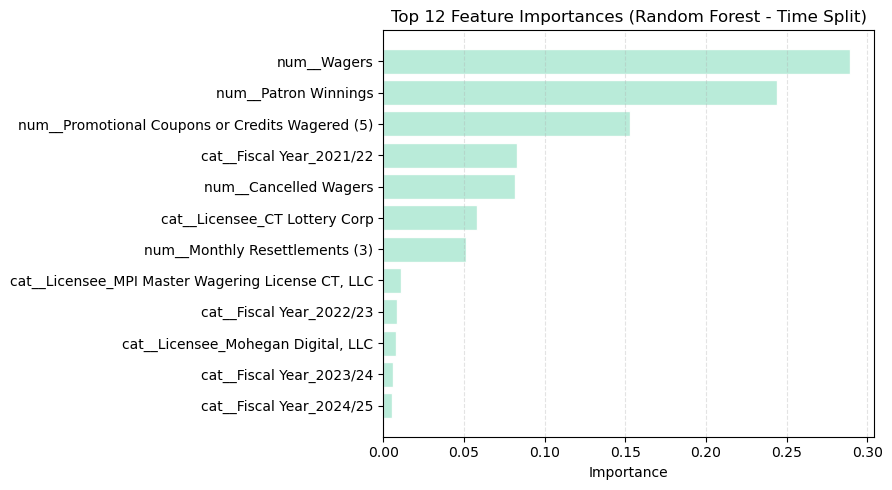

In [ ]:
preproc = rf_time.named_steps["preprocessor"]
rf_clf  = rf_time.named_steps["classifier"]

feature_names = preproc.get_feature_names_out()

importances = rf_clf.feature_importances_

fi = pd.DataFrame({
    "feature": feature_names,
    "importance": importances
}).sort_values("importance", ascending=False)

top_n = 12
fi_top = fi.head(top_n)

display(fi_top)


plt.figure(figsize=(9, 5))
plt.barh(
    fi_top["feature"][::-1],
    fi_top["importance"][::-1],
    color="#B5EAD7",     
    edgecolor="white",
    alpha=0.95
)

plt.title(f"Top {top_n} Feature Importances (Random Forest - Time Split)")
plt.xlabel("Importance")
plt.grid(axis="x", linestyle="--", alpha=0.35)
plt.tight_layout()
plt.show()


In [68]:
# Logistic Regression ROC-AUC (time split)
y_proba_log = logreg_time.predict_proba(X_test_t)[:, 1]
auc_log = roc_auc_score(y_test_t, y_proba_log)

# Random Forest ROC-AUC (time split)
y_proba_rf = rf_time.predict_proba(X_test_t)[:, 1]
auc_rf = roc_auc_score(y_test_t, y_proba_rf)

print("ROC-AUC (Logistic, time split):", round(auc_log, 4))
print("ROC-AUC (Random Forest, time split):", round(auc_rf, 4))
if auc_rf > auc_log:
    print("Random Forest outperforms Logistic Regression in terms of ROC-AUC.")
else:
    print("Logistic Regression outperforms Random Forest in terms of ROC-AUC.")


ROC-AUC (Logistic, time split): 0.9895
ROC-AUC (Random Forest, time split): 1.0
Random Forest outperforms Logistic Regression in terms of ROC-AUC.


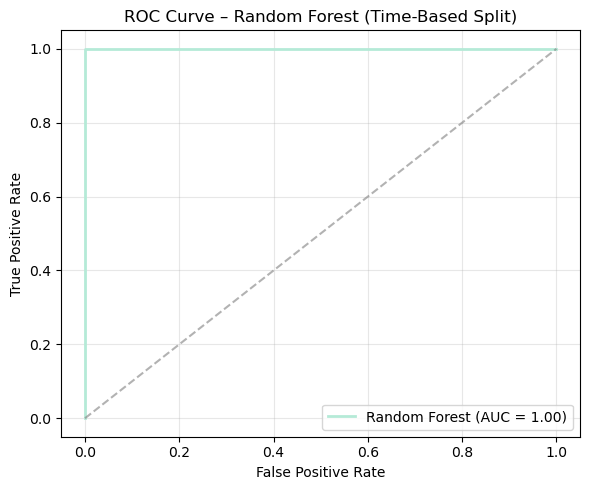

In [71]:
y_proba_rf_time = rf_time.predict_proba(X_test_t)[:, 1]

fpr, tpr, _ = roc_curve(y_test_t, y_proba_rf_time)
roc_auc_rf_time = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(
    fpr,
    tpr,
    label=f"Random Forest (AUC = {roc_auc_rf_time:.2f})",
    linewidth=2,
    color="#B5EAD7"
)

plt.plot([0, 1], [0, 1], linestyle="--", color="gray", alpha=0.6)

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Random Forest (Time-Based Split)")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [ ]:
knn_time = Pipeline(
    steps=[
        ("preprocessor", preprocessor_t),
        ("classifier", KNeighborsClassifier(n_neighbors=5))
    ]
)

knn_time.fit(X_train_t, y_train_t)

y_pred_knn_time = knn_time.predict(X_test_t)

print("Accuracy (kNN, Time-Based Split):", accuracy_score(y_test_t, y_pred_knn_time))
print("\nClassification Report (kNN):\n")
print(classification_report(y_test_t, y_pred_knn_time))


Accuracy (kNN, Time-Based Split): 0.896551724137931

Classification Report (kNN):

              precision    recall  f1-score   support

           0       0.77      1.00      0.87        10
           1       1.00      0.84      0.91        19

    accuracy                           0.90        29
   macro avg       0.88      0.92      0.89        29
weighted avg       0.92      0.90      0.90        29



In [79]:
gb_time = Pipeline(
    steps=[
        ("preprocessor", preprocessor_t),
        ("classifier", GradientBoostingClassifier(random_state=42))
    ]
)


gb_time.fit(X_train_t, y_train_t)

y_pred_gb_time = gb_time.predict(X_test_t)

print("Accuracy (Gradient Boosting, Time-Based Split):", accuracy_score(y_test_t, y_pred_gb_time))
print("\nClassification Report (Gradient Boosting):\n")
print(classification_report(y_test_t, y_pred_gb_time))


Accuracy (Gradient Boosting, Time-Based Split): 0.9655172413793104

Classification Report (Gradient Boosting):

              precision    recall  f1-score   support

           0       1.00      0.90      0.95        10
           1       0.95      1.00      0.97        19

    accuracy                           0.97        29
   macro avg       0.97      0.95      0.96        29
weighted avg       0.97      0.97      0.97        29



In [80]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Decision Tree (max_depth=5)": DecisionTreeClassifier(max_depth=5, random_state=42),
    "k-NN (k=5)": KNeighborsClassifier(n_neighbors=5),
    "Random Forest (n=200)": RandomForestClassifier(n_estimators=200, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42)
}

results = []

for name, model in models.items():
    pipe = Pipeline([
        ("preprocessor", preprocessor_t),   
        ("classifier", model)
    ])

    pipe.fit(X_train_t, y_train_t)
    y_pred = pipe.predict(X_test_t)

    auc_val = None
    if hasattr(pipe.named_steps["classifier"], "predict_proba"):
        y_proba = pipe.predict_proba(X_test_t)[:, 1]
        auc_val = roc_auc_score(y_test_t, y_proba)

    results.append({
        "Model": name,
        "Accuracy": round(accuracy_score(y_test_t, y_pred), 3),
        "F1 (macro)": round(f1_score(y_test_t, y_pred, average="macro"), 3),
        "ROC-AUC": (round(auc_val, 3) if auc_val is not None else None)
    })

results_df = (
    pd.DataFrame(results)
    .sort_values(by="F1 (macro)", ascending=False)
    .reset_index(drop=True)
)

display(results_df)


,Model,Accuracy,F1 (macro),ROC-AUC
0,Random Forest (n=200),1.000,1.000,1.000
1,Decision Tree (max_depth=5),0.966,0.961,0.950
2,Gradient Boosting,0.966,0.961,1.000
3,Logistic Regression,0.931,0.924,0.989
4,k-NN (k=5),0.897,0.892,1.000


In [81]:
cv = TimeSeriesSplit(n_splits=5)

scoring = {
    "accuracy": "accuracy",
    "precision": "precision",
    "recall": "recall",
    "f1": "f1",
    "roc_auc": "roc_auc"
}

cv_results_log_time = cross_validate(
    logreg_time, X_train_t, y_train_t, cv=cv, scoring=scoring
)

cv_results_rf_time = cross_validate(
    rf_time, X_train_t, y_train_t, cv=cv, scoring=scoring
)

def summarize_cv(name, res):
    print(f"\n{name} (5-Fold CV on TRAIN):")
    for k in scoring.keys():
        scores = res[f"test_{k}"]
        print(f"  {k}: mean={scores.mean():.3f}, std={scores.std():.3f}")

summarize_cv("Logistic Regression", cv_results_log_time)
summarize_cv("Random Forest", cv_results_rf_time)


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])



Logistic Regression (5-Fold CV on TRAIN):
  accuracy: mean=0.874, std=0.098
  precision: mean=0.775, std=0.391
  recall: mean=0.693, std=0.364
  f1: mean=0.727, std=0.370
  roc_auc: mean=0.993, std=0.009

Random Forest (5-Fold CV on TRAIN):
  accuracy: mean=0.863, std=0.113
  precision: mean=1.000, std=0.000
  recall: mean=0.675, std=0.293
  f1: mean=0.763, std=0.244
  roc_auc: mean=0.976, std=0.023


,Model,Accuracy_mean,Accuracy_std,F1_mean,F1_std,ROC_AUC_mean,ROC_AUC_std
0,Logistic Regression,0.873684,0.097617,0.727000,0.370022,0.992597,0.009451
1,Random Forest,0.863158,0.113372,0.763429,0.244022,0.976407,0.022592


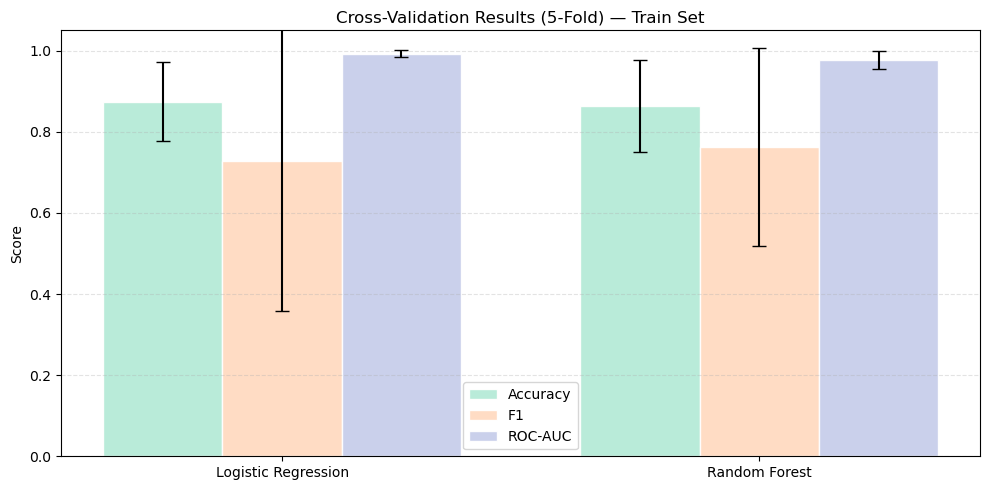

In [82]:
def cv_to_row(name, res):
    return {
        "Model": name,
        "Accuracy_mean": res["test_accuracy"].mean(),
        "Accuracy_std":  res["test_accuracy"].std(),
        "F1_mean":       res["test_f1"].mean(),
        "F1_std":        res["test_f1"].std(),
        "ROC_AUC_mean":  res["test_roc_auc"].mean(),
        "ROC_AUC_std":   res["test_roc_auc"].std(),
    }

summary = pd.DataFrame([
    cv_to_row("Logistic Regression", cv_results_log_time),
    cv_to_row("Random Forest", cv_results_rf_time)
])

display(summary)

metrics = [
    ("Accuracy", "Accuracy_mean", "Accuracy_std", "#B5EAD7"),
    ("F1",       "F1_mean",       "F1_std",       "#FFDAC1"),
    ("ROC-AUC",  "ROC_AUC_mean",  "ROC_AUC_std",  "#C7CEEA"),
]

x = np.arange(len(summary["Model"]))
bar_width = 0.25

plt.figure(figsize=(10, 5))

for i, (label, mean_col, std_col, color) in enumerate(metrics):
    plt.bar(
        x + i * bar_width,
        summary[mean_col],
        yerr=summary[std_col],
        width=bar_width,
        color=color,
        edgecolor="white",
        capsize=5,
        alpha=0.95,
        label=label
    )

plt.xticks(x + bar_width, summary["Model"], rotation=0)
plt.ylim(0, 1.05)
plt.title("Cross-Validation Results (5-Fold) — Train Set")
plt.ylabel("Score")
plt.grid(axis="y", linestyle="--", alpha=0.35)
plt.legend()
plt.tight_layout()
plt.show()


In [83]:
preproc = rf_time.named_steps["preprocessor"]
rf_clf  = rf_time.named_steps["classifier"]

feature_names = preproc.get_feature_names_out()
importances = rf_clf.feature_importances_

importance_df = (
    pd.DataFrame({"feature": feature_names, "importance": importances})
    .sort_values("importance", ascending=False)
)

display(importance_df.head(10))


,feature,importance
0,num__Wagers,0.289570
1,num__Patron Winnings,0.244200
4,num__Promotional Coupons or Credits Wagered (5),0.152937
8,cat__Fiscal Year_2021/22,0.082952
2,num__Cancelled Wagers,0.081840
5,cat__Licensee_CT Lottery Corp,0.058059
3,num__Monthly Resettlements (3),0.051567
6,"cat__Licensee_MPI Master Wagering License CT, LLC",0.010896
9,cat__Fiscal Year_2022/23,0.008478
7,"cat__Licensee_Mohegan Digital, LLC",0.008116


In [84]:
numeric_features = [
    'Wagers',
    'Patron Winnings',
    'Cancelled Wagers',
    'Monthly Resettlements (3)',
    'Online Sports Wagering Win/(Loss)',
    'Federal Excise Tax (4)',
    'Unadjusted Monthly Gaming Revenue',
    'Promotional Coupons or Credits Wagered (5)',
    'Promotional Deduction (6)',
    'Payment (7)'
]

X_unsupervised = df[numeric_features]

# Isolation Forest
iso_forest = IsolationForest(
    n_estimators=200,
    contamination=0.05,
    random_state=42
)

X_unsupervised_scaled = StandardScaler().fit_transform(X_unsupervised)
df["anomaly"] = iso_forest.fit_predict(X_unsupervised_scaled)

# -1 = anomaly, 1 = normal
df['anomaly'].value_counts()


anomaly
 1    136
-1      8
Name: count, dtype: int64

In [85]:
df[df["anomaly"]==-1][["Month Ending"] + numeric_features].head()

,Month Ending,Wagers,Patron Winnings,Cancelled Wagers,Monthly Resettlements (3),Online Sports Wagering Win/(Loss),Federal Excise Tax (4),Unadjusted Monthly Gaming Revenue,Promotional Coupons or Credits Wagered (5),Promotional Deduction (6),Payment (7)
0,2021-10-31,3246536,2901339,41418,10047,293732,8013,285720,404431,71430,29465
46,2023-01-31,67274953,57056212,881477,127060,9210202,160658,9049544,2130210,1809909,995450
78,2023-12-31,92038912,82429538,129992,-3568,9482950,223872,9259078,4785425,1388862,1082155
79,2023-12-31,98149690,86430774,195903,34754,11488259,240122,11248137,1904895,1687221,1314626
82,2024-01-31,96535391,83042846,336097,22085,13134363,230179,12904184,4127515,1935628,1508177


Num anomalies: 8


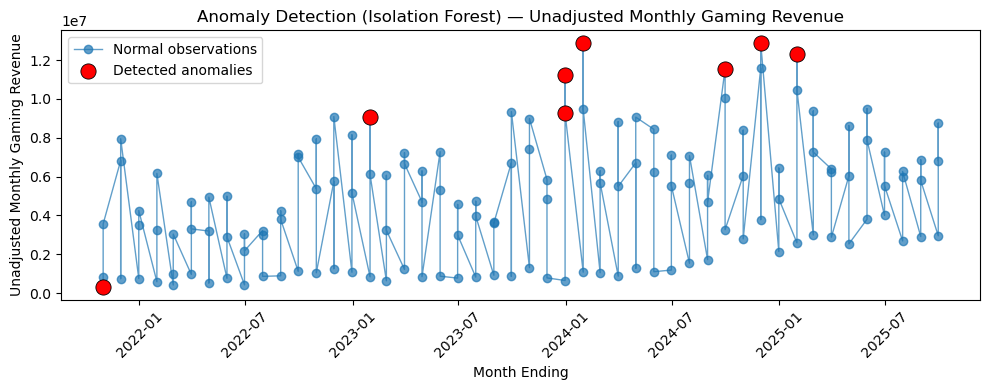

In [ ]:
col = "Unadjusted Monthly Gaming Revenue"

df_plot = df.sort_values("Month Ending").copy()
is_anom = df_plot["anomaly"] == -1

print("Num anomalies:", is_anom.sum())

plt.figure(figsize=(10, 4))

plt.plot(
    df_plot["Month Ending"],
    df_plot[col],
    marker="o",
    linewidth=1,
    label="Normal observations",
    alpha=0.7,
    zorder=1
)

plt.scatter(
    df_plot.loc[is_anom, "Month Ending"],
    df_plot.loc[is_anom, col],
    s=120,                
    color="red",
    edgecolor="black",     
    linewidth=0.6,
    zorder=5,             
    label="Detected anomalies"
)

plt.title(f"Anomaly Detection (Isolation Forest) — {col}")
plt.xlabel("Month Ending")
plt.ylabel(col)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [87]:
numeric_features = [
    'Wagers',
    'Patron Winnings',
    'Cancelled Wagers',
    'Monthly Resettlements (3)',
    'Online Sports Wagering Win/(Loss)',
    'Federal Excise Tax (4)',
    'Unadjusted Monthly Gaming Revenue',
    'Promotional Coupons or Credits Wagered (5)',
    'Promotional Deduction (6)',
    'Payment (7)'
]

X_cluster = df[numeric_features]


In [88]:
scaler = StandardScaler()
X_cluster_scaled = scaler.fit_transform(X_cluster)


In [89]:
sil_scores = {}

for k in range(2, 6):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_cluster_scaled)
    score = silhouette_score(X_cluster_scaled, labels)
    sil_scores[k] = score
    print(f"k={k}, silhouette score={score:.3f}")


k=2, silhouette score=0.466
k=3, silhouette score=0.374
k=4, silhouette score=0.369
k=5, silhouette score=0.360


In [90]:
# Final K-Means with optimal k=2
kmeans = KMeans(n_clusters=2, random_state=42)
df["cluster"] = kmeans.fit_predict(X_cluster_scaled)

df["cluster"].value_counts()
# Assign each month to a cluster based on financial activity patterns


cluster
1    78
0    66
Name: count, dtype: int64

In [91]:
cluster_summary = df.groupby("cluster")[numeric_features].mean()
cluster_summary


,Wagers,Patron Winnings,Cancelled Wagers,Monthly Resettlements (3),Online Sports Wagering Win/(Loss),Federal Excise Tax (4),Unadjusted Monthly Gaming Revenue,Promotional Coupons or Credits Wagered (5),Promotional Deduction (6),Payment (7)
cluster,,,,,,,,,,
0,2.371114e+07,2.159255e+07,104521.742424,27597.469697,1.986474e+06,57519.287879,1.928955e+06,7.237075e+05,3.477714e+05,217412.712121
1,7.011203e+07,6.254449e+07,245654.769231,13555.923077,7.308330e+06,169448.923077,7.138881e+06,1.987464e+06,1.215758e+06,814429.525641


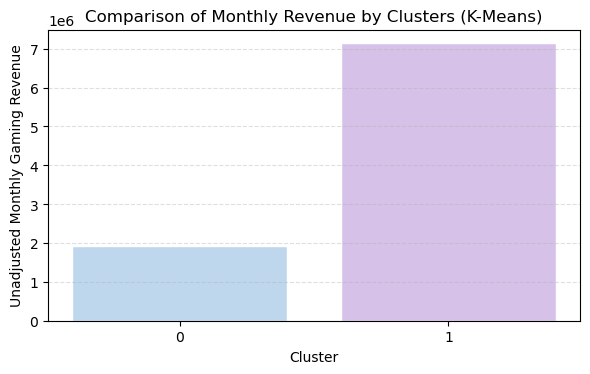

In [92]:
# Average monthly revenue per cluster
cluster_means = df.groupby("cluster")["Unadjusted Monthly Gaming Revenue"].mean()

plt.figure(figsize=(6, 4))

plt.bar(
    cluster_means.index.astype(str),
    cluster_means.values,
    color=["#BFD7ED", "#D6C1E8"],
    edgecolor="white"
)

plt.title("Comparison of Monthly Revenue by Clusters (K-Means)", fontsize=12)
plt.xlabel("Cluster")
plt.ylabel("Unadjusted Monthly Gaming Revenue")
plt.grid(axis="y", linestyle="--", alpha=0.4)

plt.tight_layout()
plt.show()


In [93]:
ct = pd.crosstab(df["cluster"], df["anomaly"]).reindex(columns=[-1, 1], fill_value=0)
ct.columns = ["Anomaly (-1)", "Normal (1)"]
ct


,Anomaly (-1),Normal (1)
cluster,,
0,1,65
1,7,71
